In [5]:
import yfinance as yf
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import talib
import math

In [2]:
index_list = [
    # 米国株主要指数
    "^GSPC", "^DJI", "^IXIC", "^RUT", "^NYA", "^SOX",
    # 米国株先物
    "ES=F", "YM=F", "NQ=F", "RTY=F",
    # ヨーロッパ主要指数
    "^GDAXI", "^FCHI", "^FTSE", "^STOXX50E",
    # コモディティ先物
    "GC=F", "SI=F", "CL=F", "NG=F", "HG=F",
    # 債券・金利関連
    "ZB=F", "ZN=F", "ZT=F", "^TNX",
    # 為替

    # ボラティリティ
    "^VIX",

    # 1. セクターETF (米国株を業種別に分割)
    "XLB",   # 素材 (Materials)
    "XLC",   # コミュニケーションサービス (Communication Services)
    "XLE",   # エネルギー (Energy)
    "XLF",   # 金融 (Financials)
    "XLI",   # 資本財 (Industrials)
    "XLK",   # テクノロジー (Technology)
    "XLP",   # 生活必需品 (Consumer Staples)
    "XLU",   # 公益事業 (Utilities)
    "XLV",   # ヘルスケア (Healthcare)
    "XLY",   # 一般消費財 (Consumer Discretionary)
    "XLRE",  # 不動産 (Real Estate)

    # 2. 幅広い市場 (米国株中心)
    "SPY",   # SPDR S&P 500
    "VOO",   # Vanguard S&P 500
    "VTI",   # Vanguard Total Stock Market
    "QQQ",   # Invesco QQQ (Nasdaq100)
    "DIA",   # SPDR Dow Jones Industrial Average
    "IWM",   # iShares Russell 2000

    # 3. コモディティ / 商品関連ETF
    "GLD",   # SPDR Gold Shares (金)
    "SLV",   # iShares Silver Trust (銀)
    "USO",   # United States Oil Fund (原油)
    "DBA",   # Invesco DB Agriculture Fund (農産物)

    # 4. 債券ETF
    "TLT",   # iShares 20+ Year Treasury Bond
    "IEF",   # iShares 7-10 Year Treasury Bond
    "IEI",   # iShares 3-7 Year Treasury Bond
    "SHY",   # iShares 1-3 Year Treasury Bond
    "HYG",   # iShares High Yield Corporate Bond (ハイイールド債)
    "LQD",   # iShares Investment Grade Corporate Bond (投資適格社債)
    "BND",   # Vanguard Total Bond Market

    # 5. 海外市場・地域別ETF
    "EFA",   # iShares MSCI EAFE (欧州・豪州・極東先進国)
    "EEM",   # iShares MSCI Emerging Markets (新興国)
    "VEA",   # Vanguard FTSE Developed Markets
    "VWO",   # Vanguard FTSE Emerging Markets
    "EWJ",   # iShares MSCI Japan
    "FXI",   # iShares China Large-Cap
]

representative_stocks = {
    "1377.T": "サカタのタネ",    # 水産・農林業
    "1605.T": "INPEX",          # 鉱業
    "1925.T": "大和ハウス工業",   # 建設業
    "2914.T": "JT",             # 食料品
    "3402.T": "東レ",           # 繊維製品
    "3861.T": "王子HD",         # パルプ・紙
    "4063.T": "信越化学工業",     # 化学
    "4519.T": "中外製薬",        # 医薬品
    "5020.T": "ENEOSHD",        # 石油・石炭製品
    "5108.T": "ブリヂストン",     # ゴム製品
    "5201.T": "AGC",            # ガラス・土石製品
    "5401.T": "日本製鉄",        # 鉄鋼
    "5713.T": "住友金属鉱山",     # 非鉄金属
    "5938.T": "LIXIL",          # 金属製品
    "6367.T": "ダイキン工業",     # 機械
    "6758.T": "ソニーG",         # 電気機器
    "7203.T": "トヨタ自動車",     # 輸送用機器
    "7741.T": "HOYA",           # 精密機器
    "7974.T": "任天堂",          # その他製品
    "9503.T": "関西電力",        # 電気・ガス業
    "9022.T": "JR東海",         # 陸運業
    "9101.T": "日本郵船",        # 海運業
    "9202.T": "ANAHD",          # 空運業
    "9301.T": "三菱倉庫",        # 倉庫・運輸関連業
    "9984.T": "ソフトバンクG",     # 情報・通信業
    "8001.T": "伊藤忠商事",       # 卸売業
    "9983.T": "ファーストリテイリング", # 小売業
    "8306.T": "三菱UFJFG",       # 銀行業
    "8604.T": "野村HD",          # 証券業
    "8766.T": "東京海上HD",       # 保険業
    "8591.T": "オリックス",       # その他金融業
    "8802.T": "三菱地所",        # 不動産業
    "6098.T": "リクルートHD",     # サービス業
}

In [3]:
start_date = "2021-01-01"
end_date   = "2024-12-31"

# 指標データを格納する辞書
index_data = {}

for idx in index_list:
    df_idx = yf.download(idx, start=start_date, end=end_date)
    
    # 日次リターン (当日)
    df_idx["ret_idx"] = (df_idx["Close"] - df_idx["Open"]) / df_idx["Open"]
    # 前日分をずらす
    df_idx["ret_idx_s1"] = df_idx["ret_idx"].shift(1)
    
    # 日付をIndexとして必要列のみ保持
    index_data[idx] = df_idx[["ret_idx_s1"]].copy()

# 結果を格納するリスト
result_rows = []

for ticker, name in representative_stocks.items():
    # 1) 該当銘柄データを取得
    df_stock = yf.download(ticker, start=start_date, end=end_date)
    # 日次リターン (当日)
    df_stock["ret_target"] = (df_stock["Close"] - df_stock["Open"]) / df_stock["Open"]
    
    # 計算用の行データ（＝後でDataFrame化する）
    row_dict = {
        "Ticker": ticker,
        "Name":   name
    }
    
    # 2) それぞれの指標との相関を計算
    for idx in index_list:
        # index_data[idx] は既に前日リターンを持っている DataFrame
        df_merge = pd.merge(
            df_stock[["ret_target"]],   # 当日リターン
            index_data[idx],            # 前日リターン(ret_idx_s1)
            left_index=True,
            right_index=True,
            how="inner"
        )
        # 欠損除去
        df_merge.dropna(inplace=True)
        
        if len(df_merge) == 0:
            corr_val = np.nan
        else:
            corr_val = df_merge["ret_target"].corr(df_merge["ret_idx_s1"])
        
        # 行データに追加
        row_dict[idx] = corr_val
    
    result_rows.append(row_dict)

# 5) リストからDataFrameを作成
df_result = pd.DataFrame(result_rows)





[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

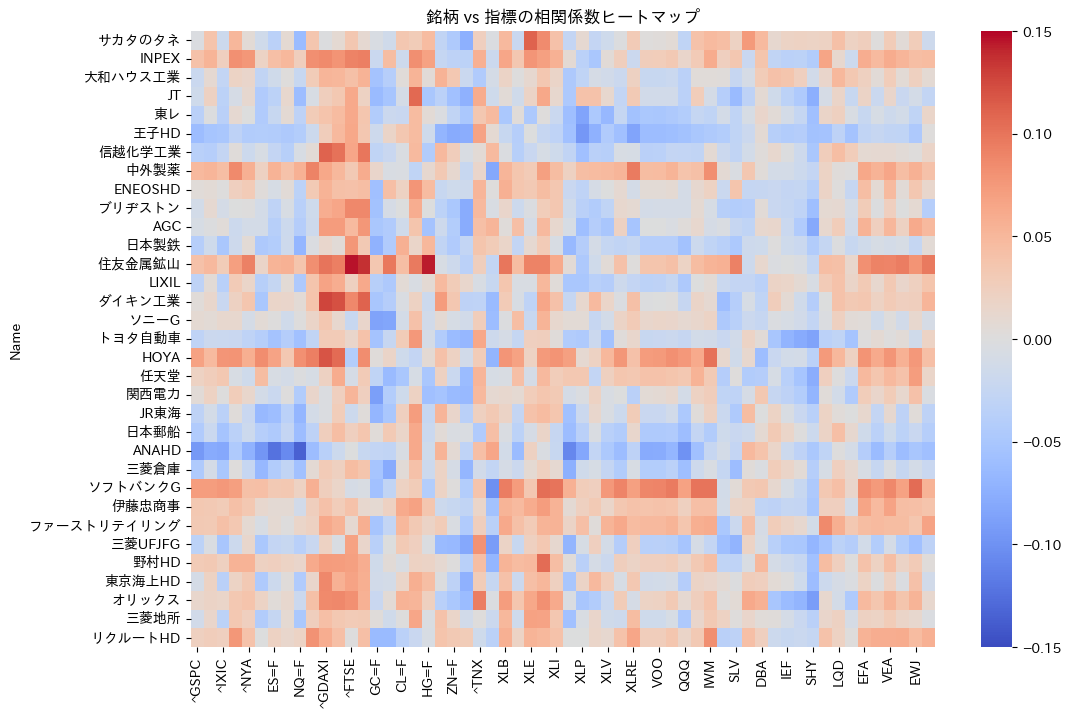

In [4]:
# ヒートマップ表示用のDataFrameを作成
df_heatmap = df_result.set_index("Name")[index_list]

# 2) ヒートマップ描画
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_heatmap,
    annot=False,     # セルに数値を表示
    cmap="coolwarm",# カラーマップ（青〜赤系）
    fmt=".2f",      # 相関係数を小数点以下2桁で表示
    vmin=-0.15, vmax=0.15 # 相関の範囲を -1〜1 に固定
)

plt.title("銘柄 vs 指標の相関係数ヒートマップ")
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

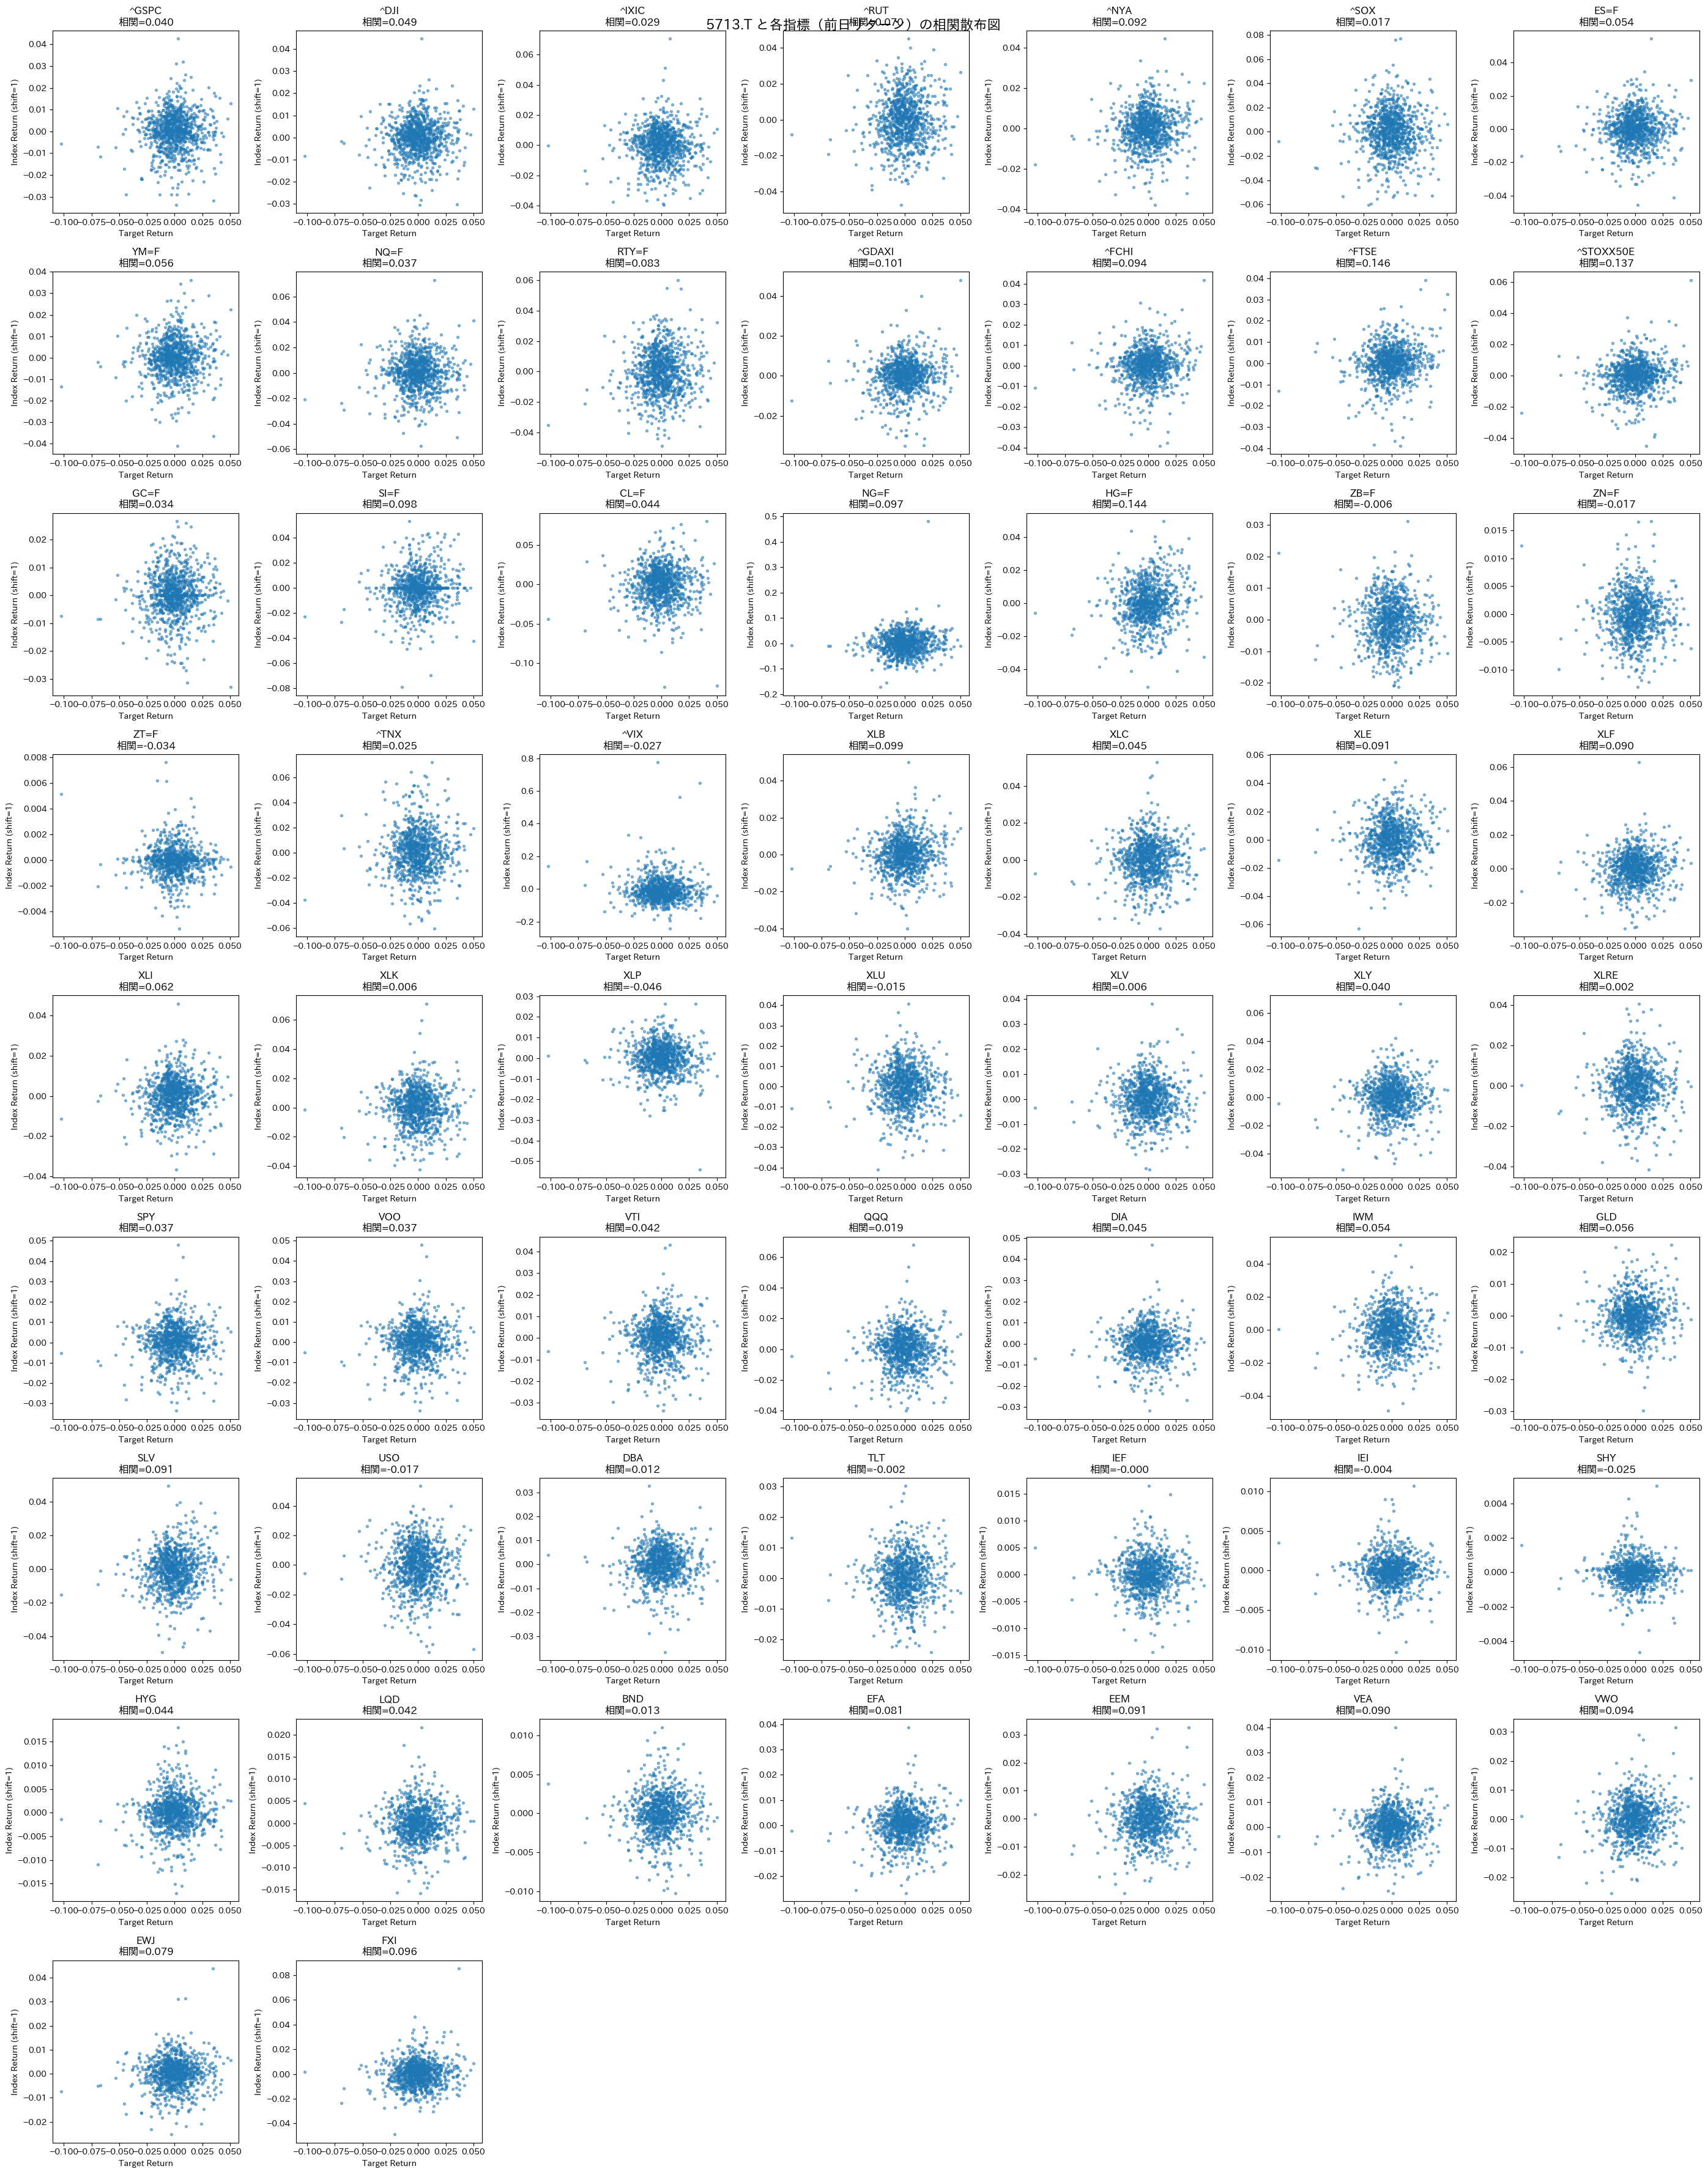

=== 相関係数一覧 ===
           Correlation
^FTSE         0.146194
HG=F          0.143703
^STOXX50E     0.136947
^GDAXI        0.100778
XLB           0.099120
SI=F          0.098060
NG=F          0.097242
FXI           0.096437
VWO           0.093990
^FCHI         0.093513
^NYA          0.091927
SLV           0.091478
XLE           0.090808
EEM           0.090776
XLF           0.090359
VEA           0.089819
RTY=F         0.082668
EFA           0.080883
EWJ           0.079159
^RUT          0.070437
XLI           0.061559
YM=F          0.056138
GLD           0.055665
IWM           0.053884
ES=F          0.053695
^DJI          0.048887
DIA           0.045052
XLC           0.045052
CL=F          0.044342
HYG           0.044192
LQD           0.042083
VTI           0.041759
^GSPC         0.040341
XLY           0.039892
VOO           0.037252
NQ=F          0.036971
SPY           0.036916
GC=F          0.034404
^IXIC         0.028760
^TNX          0.024952
QQQ           0.019358
^SOX          0.016

In [6]:
# ---- 1. 比較対象とする銘柄・期間を設定 ----
target_ticker = "5713.T"  
start_date = "2021-01-01"
end_date   = "2024-12-31"

# ---- 2. 銘柄データの取得とリターン計算 ----
df_target = yf.download(target_ticker, start=start_date, end=end_date)
df_target["ret_target"] = (df_target["Close"] - df_target["Open"]) / df_target["Open"]


# ---- 4. サブプロットのレイアウトを設定 ----
n_indices = len(index_list)
cols = 7  # 1行あたり5つのサブプロット
rows = math.ceil(n_indices / cols)

# figure 全体を作成 (横: 5列分 * 適宜サイズ, 縦: 行数に応じたサイズ)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4), tight_layout=True)
# axes が二次元配列で返るため、フラットにして扱う
axes = axes.flatten()

# ---- 5. 各指標について相関を計算し、散布図を作成 ----
result_corr = {}

for i, idx in enumerate(index_list):
    # サブプロット用のaxesを取り出す
    ax = axes[i]
    
    # 指標データ取得
    df_idx = yf.download(idx, start=start_date, end=end_date)
    # 日次リターンを計算し、前日のリターンをshift(1)でずらす
    df_idx["ret_idx"] = (df_idx["Close"] - df_idx["Open"]) / df_idx["Open"]
    df_idx["ret_idx_s1"] = df_idx["ret_idx"].shift(1)
    
    # 銘柄と指標を同じ日付に合わせて結合
    df_merge = pd.DataFrame({
        'ret_target': df_target["ret_target"],
        'ret_idx_s1': df_idx["ret_idx_s1"],
    })
    df_merge.dropna(inplace=True)
    
    # 相関係数の計算
    corr_value = df_merge["ret_target"].corr(df_merge["ret_idx_s1"])
    result_corr[idx] = corr_value
    
    # 散布図を描画
    ax.scatter(df_merge["ret_target"], df_merge["ret_idx_s1"], alpha=0.5, s=8)
    ax.set_title(f'{idx}\n相関={corr_value:.3f}')
    ax.set_xlabel("Target Return")
    ax.set_ylabel("Index Return (shift=1)")

# 余っているサブプロットがあれば非表示化（指標数がcols*rows未満の場合）
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# ---- 6. 全てのグラフをレイアウトして表示 ----
plt.suptitle(f"{target_ticker} と各指標（前日リターン）の相関散布図", fontsize=16)
plt.subplots_adjust(top=0.50)  # タイトルが見切れないようにマージン調整
plt.show()

# ---- 7. 最終的な相関値一覧を表示 ----
result_corr_df = pd.DataFrame.from_dict(result_corr, orient='index', columns=["Correlation"])
print("=== 相関係数一覧 ===")
print(result_corr_df.sort_values("Correlation", ascending=False))


https://indexes.nikkei.co.jp/nkave/archives/file/nikkei_225_price_adjustment_factor_jp.csv

In [7]:
import csv

nikkei225_dict = {}
with open("./data/nikkei_225_price_adjustment_factor_jp.csv",encoding="shift-jis") as f:
    reader = csv.DictReader(f)
    for row in reader:
        ticker = row["コード"].strip() + ".T"
        name   = row["銘柄名"].strip()
        nikkei225_dict[ticker] = name

nikkei225_dict

{'1332.T': 'ニッスイ',
 '1605.T': 'ＩＮＰＥＸ',
 '1721.T': 'コムシスホールディングス',
 '1801.T': '大成建設',
 '1802.T': '大林組',
 '1803.T': '清水建設',
 '1808.T': '長谷工コーポレーション',
 '1812.T': '鹿島建設',
 '1925.T': '大和ハウス工業',
 '1928.T': '積水ハウス',
 '1963.T': '日揮ホールディングス',
 '2002.T': '日清製粉グループ本社',
 '2269.T': '明治ホールディングス',
 '2282.T': '日本ハム',
 '2413.T': 'エムスリー',
 '2432.T': 'ディー・エヌ・エー',
 '2501.T': 'サッポロホールディングス',
 '2502.T': 'アサヒグループホールディングス',
 '2503.T': 'キリンホールディングス',
 '2768.T': '双日',
 '2801.T': 'キッコーマン',
 '2802.T': '味の素',
 '2871.T': 'ニチレイ',
 '2914.T': '日本たばこ産業',
 '3086.T': 'Ｊ．フロントリテイリング',
 '3092.T': 'ＺＯＺＯ',
 '3099.T': '三越伊勢丹ホールディングス',
 '3289.T': '東急不動産ホールディングス',
 '3382.T': 'セブン＆アイ・ホールディングス',
 '3401.T': '帝人',
 '3402.T': '東レ',
 '3405.T': 'クラレ',
 '3407.T': '旭化成',
 '3436.T': 'ＳＵＭＣＯ',
 '3659.T': 'ネクソン',
 '3861.T': '王子ホールディングス',
 '4004.T': 'レゾナック・ホールディングス',
 '4005.T': '住友化学',
 '4021.T': '日産化学',
 '4042.T': '東ソー',
 '4043.T': 'トクヤマ',
 '4061.T': 'デンカ',
 '4063.T': '信越化学工業',
 '4151.T': '協和キリン',
 '4183.T': '三井化学',
 '4188.T': '三菱ケミカルグループ',


In [8]:
import numpy as np

# -- 2) 指標ごとのデータを先に取得＆前日リターンを計算 --
start_date = "2021-01-01"
end_date   = "2024-12-31"

index_data = {}
for idx in index_list:
    df_idx = yf.download(idx, start=start_date, end=end_date)
    # 日次リターン
    df_idx["ret_idx"] = (df_idx["Close"] - df_idx["Open"]) / df_idx["Open"]
    df_idx["ret_idx_s1"] = df_idx["ret_idx"].shift(1)
    index_data[idx] = df_idx[["ret_idx_s1"]]

# -- 3) 日経225の各銘柄との相関を計算し、df_resultを作成 --
result_rows = []
for ticker, name in nikkei225_dict.items():
    # yfinance で銘柄をダウンロード
    df_stock = yf.download(ticker, start=start_date, end=end_date)
    # 当日リターン
    df_stock["ret_target"] = (df_stock["Close"] - df_stock["Open"]) / df_stock["Open"]
    
    row_dict = {
        "Ticker": ticker,
        "Name":   name,
    }
    
    # 指標一覧との相関を順番に計算
    for idx in index_list:
        df_merge = pd.merge(
            df_stock[["ret_target"]],
            index_data[idx],
            left_index=True,
            right_index=True,
            how="inner"
        )
        df_merge.dropna(inplace=True)
        
        if len(df_merge) == 0:
            corr_val = np.nan
        else:
            corr_val = df_merge["ret_target"].corr(df_merge["ret_idx_s1"])
        
        row_dict[idx] = corr_val
    
    result_rows.append(row_dict)

df_result = pd.DataFrame(result_rows)

df_result.head()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

,Ticker,Name,^GSPC,^DJI,^IXIC,^RUT,^NYA,^SOX,ES=F,YM=F,...,SHY,HYG,LQD,BND,EFA,EEM,VEA,VWO,EWJ,FXI
0,1332.T,ニッスイ,-0.021172,0.012664,-0.024604,-0.002402,-0.004273,-0.038843,-0.036187,-0.005395,...,-0.043555,-0.022211,-0.001130,-0.022075,0.026679,-0.011885,0.019108,-0.015265,0.013411,-0.029372
1,1605.T,ＩＮＰＥＸ,0.040280,0.052994,0.023602,0.081377,0.076853,0.019700,0.042490,0.049810,...,-0.042534,0.065910,0.012050,-0.017665,0.059224,0.047930,0.060910,0.051981,0.043581,0.045742
2,1721.T,コムシスホールディングス,-0.016381,0.009575,-0.015820,-0.010956,-0.031471,-0.031019,-0.033798,-0.021633,...,-0.062617,0.000288,-0.002330,-0.027665,0.006123,-0.008302,0.004852,-0.010598,0.004655,-0.020600
3,1801.T,大成建設,0.006965,0.037097,-0.006234,0.039912,0.017336,-0.022468,-0.001932,0.026245,...,-0.016731,-0.009082,-0.003054,-0.007746,0.012537,0.021545,0.017717,0.012970,0.018904,0.009728
4,1802.T,大林組,-0.007809,0.016146,-0.016797,0.010291,-0.017511,-0.043586,-0.032173,-0.005661,...,-0.073267,-0.027096,-0.004463,-0.031535,0.013055,-0.001888,0.016969,-0.006699,0.027907,-0.016150


In [29]:
df_melted = df_result.melt(
    id_vars=["Ticker", "Name"],  # これらの列はそのまま
    var_name="Index",            # たとえば "指標" の列名
    value_name="Correlation"     # 相関係数
)

# 今作った df_melted から、相関が 0.1以上 or -0.1以下 の行のみ抽出
df_filtered = df_melted[
    (df_melted["Correlation"] >= 0.1)
].copy()

df_filtered.sort_values(by="Correlation", ascending=False, inplace=True)
df_filtered

,Ticker,Name,Index,Correlation
4041,9531.T,東京瓦斯,NG=F,0.172295
7254,4507.T,塩野義製薬,XLV,0.151720
2784,5713.T,住友金属鉱山,^FTSE,0.146194
4134,5713.T,住友金属鉱山,HG=F,0.143703
8379,4507.T,塩野義製薬,VTI,0.140503
...,...,...,...,...
7671,2802.T,味の素,XLRE,0.100797
2334,5713.T,住友金属鉱山,^GDAXI,0.100778
2798,6305.T,日立建機,^FTSE,0.100776
3908,5711.T,三菱マテリアル,NG=F,0.100622


In [10]:
import yfinance as yf
ohlcv = yf.download("9531.T",start="2021-01-01",end="2024-12-31",interval="1d")
ohlcv.isnull().sum()

[*********************100%***********************]  1 of 1 completed


Price   Ticker
Close   9531.T    0
High    9531.T    0
Low     9531.T    0
Open    9531.T    0
Volume  9531.T    0
dtype: int64

In [11]:
ohlcv.describe()

Price,Close,High,Low,Open,Volume
Ticker,9531.T,9531.T,9531.T,9531.T,9531.T
count,980.000000,980.000000,980.000000,980.000000,9.800000e+02
mean,2706.546578,2737.108067,2678.075399,2705.558697,1.523021e+06
std,653.917861,666.756306,644.902703,653.830693,7.748540e+05
min,1737.134766,1756.219017,1726.428858,1741.323853,2.181000e+05
25%,2132.309082,2152.867355,2109.421099,2130.524734,1.073475e+06
50%,2469.218872,2495.573077,2446.743626,2471.637216,1.348700e+06
75%,3297.340881,3339.804600,3253.978685,3298.201688,1.707650e+06
max,4558.000000,4637.000000,4516.000000,4582.000000,7.318000e+06


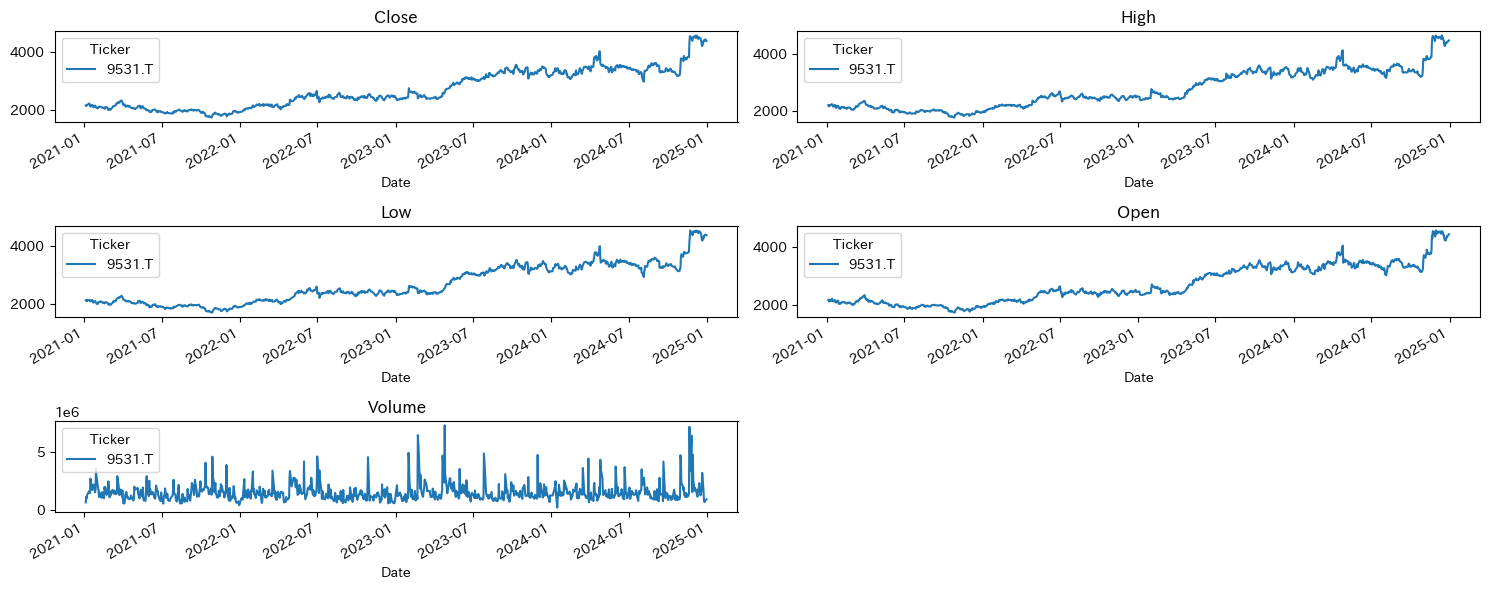

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
fig = plt.figure(figsize=(15,6))

for i,feature in enumerate(["Close","High","Low","Open","Volume"]):
    ax = plt.subplot(3,2,i+1)
    ax.set_title(feature)
    ohlcv[feature].plot(ax=ax)
plt.tight_layout()

In [13]:
ohlcv["return"] = (ohlcv["Close"] - ohlcv["Open"]) / ohlcv["Open"]
ohlcv

Price,Close,High,Low,Open,Volume,return
Ticker,9531.T,9531.T,9531.T,9531.T,9531.T,
Date,,,,,,
2021-01-04,2150.768311,2189.774231,2144.872067,2175.260400,661800,-0.011259
2021-01-05,2135.801270,2162.107592,2126.730124,2162.107592,1134300,-0.012167
2021-01-06,2145.325684,2145.779241,2111.308892,2120.833593,1003600,0.011548
2021-01-07,2158.479004,2192.949356,2154.850546,2188.413783,1280900,-0.013679
2021-01-08,2175.260498,2177.981841,2133.986790,2144.872163,1371300,0.014168
...,...,...,...,...,...,...
2024-12-24,4394.000000,4402.000000,4332.000000,4341.000000,926800,0.012209
2024-12-25,4368.000000,4386.000000,4315.000000,4377.000000,684300,-0.002056


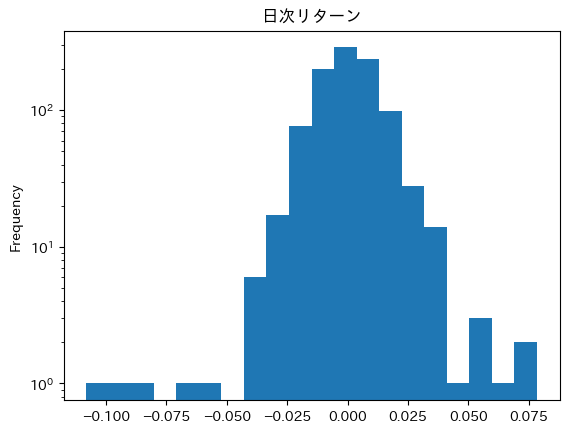

In [14]:
plt.title("日次リターン")
ohlcv["return"].plot(kind="hist",bins=20)
plt.yscale("log")

In [15]:
desc_1 = yf.download("NG=F",start="2021-01-01",end="2024-12-31", interval="1d")
desc_1

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NG=F,NG=F,NG=F,NG=F,NG=F
Date,,,,,
2021-01-04,2.581,2.670,2.566,2.626,128377
2021-01-05,2.702,2.732,2.591,2.599,149828
2021-01-06,2.716,2.770,2.606,2.688,144690
2021-01-07,2.729,2.755,2.663,2.722,135480
2021-01-08,2.700,2.730,2.626,2.675,148730
...,...,...,...,...,...
2024-12-23,3.656,3.944,3.581,3.869,125622
2024-12-24,3.946,3.958,3.666,3.695,66852


In [16]:
#desc_1.columns = desc_1.columns.droplevel(1)
desc_1["desc_1_return"] = (desc_1["Close"] - desc_1["Open"] ) / desc_1["Open"]
desc_1

Price,Close,High,Low,Open,Volume,desc_1_return
Ticker,NG=F,NG=F,NG=F,NG=F,NG=F,
Date,,,,,,
2021-01-04,2.581,2.670,2.566,2.626,128377,-0.017136
2021-01-05,2.702,2.732,2.591,2.599,149828,0.039631
2021-01-06,2.716,2.770,2.606,2.688,144690,0.010417
2021-01-07,2.729,2.755,2.663,2.722,135480,0.002572
2021-01-08,2.700,2.730,2.626,2.675,148730,0.009346
...,...,...,...,...,...,...
2024-12-23,3.656,3.944,3.581,3.869,125622,-0.055053
2024-12-24,3.946,3.958,3.666,3.695,66852,0.067930


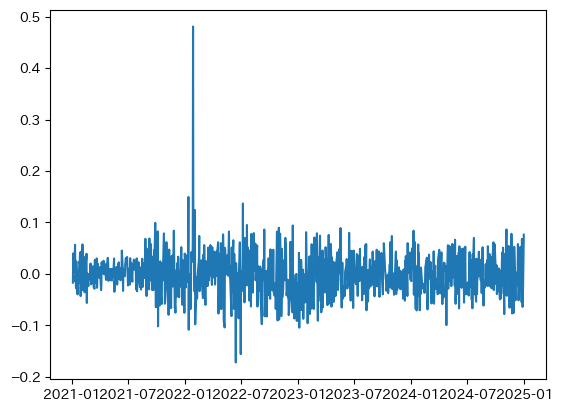

In [17]:
plt.plot(desc_1["desc_1_return"])

In [18]:
import pandas as pd

In [19]:
merged_df = ohlcv.merge(desc_1,on="Date",how="left")
merged_df

Price,Close,High,Low,Open,Volume,return,Close,High,Low,Open,Volume,desc_1_return
Ticker,9531.T,9531.T,9531.T,9531.T,9531.T,,NG=F,NG=F,NG=F,NG=F,NG=F,
Date,,,,,,,,,,,,
2021-01-04,2150.768311,2189.774231,2144.872067,2175.260400,661800,-0.011259,2.581,2.670,2.566,2.626,128377.0,-0.017136
2021-01-05,2135.801270,2162.107592,2126.730124,2162.107592,1134300,-0.012167,2.702,2.732,2.591,2.599,149828.0,0.039631
2021-01-06,2145.325684,2145.779241,2111.308892,2120.833593,1003600,0.011548,2.716,2.770,2.606,2.688,144690.0,0.010417
2021-01-07,2158.479004,2192.949356,2154.850546,2188.413783,1280900,-0.013679,2.729,2.755,2.663,2.722,135480.0,0.002572
2021-01-08,2175.260498,2177.981841,2133.986790,2144.872163,1371300,0.014168,2.700,2.730,2.626,2.675,148730.0,0.009346
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,4394.000000,4402.000000,4332.000000,4341.000000,926800,0.012209,3.946,3.958,3.666,3.695,66852.0,0.067930
2024-12-25,4368.000000,4386.000000,4315.000000,4377.000000,684300,-0.002056,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
import numpy as np
strategy1 = merged_df.copy()
strategy1["desc_1_return_sign"] = np.sign(strategy1["desc_1_return"])
strategy1["desc_1_return_sign_s1"] = strategy1["desc_1_return_sign"].shift(1)

<Axes: title={'center': 'desc_1_return_s1'}, xlabel='desc_1_return_sign_s1'>

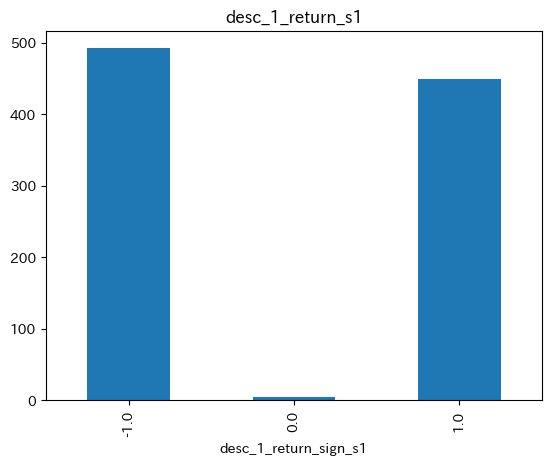

In [21]:
plt.title("desc_1_return_s1")
strategy1.groupby("desc_1_return_sign_s1").size().plot(kind="bar")

In [22]:
strategy1["signal"] = 0
strategy1.loc[strategy1["desc_1_return_sign_s1"] == 1,"signal"] = 1
strategy1.loc[strategy1["desc_1_return_sign_s1"] == -1,"signal"] = -1

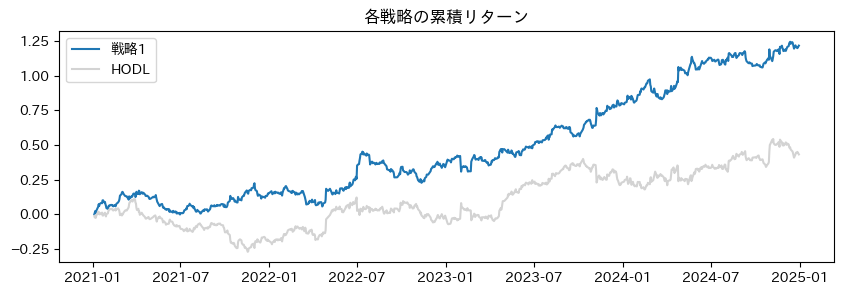

In [24]:
fig = plt.figure(figsize=(10,3))
plt.title("各戦略の累積リターン")
plt.plot((strategy1["signal"]*strategy1["return"]).cumsum(),label="戦略1")
plt.plot(strategy1['return'].cumsum(), label='HODL', color='lightgray')
plt.legend()

In [25]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()